# Online Analytical Processing (OLAP) : Based on Victim Age

Code written by: Aparajita Satish Ramanathan (Student ID:862324503)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import os
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, BooleanType
from pyspark.sql.functions import to_timestamp, concat, lit, udf, upper, to_timestamp, to_date

In [2]:
import seaborn as sns

In [3]:
from pyspark.sql.functions import to_timestamp,date_format
from pyspark.sql.functions import year, substring


In [4]:
df = pd.read_csv('Crime_Data_from_2010_to_2019.csv')

In [5]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


### Unique Victim Age in our Dataset

In [6]:
df['Vict Age'].unique()

array([ 48,   0,  47,  23,  46,  51,  30,  55,  38,  40,  24,  29,  41,
        11,  50,  18,  37,  28,  25,  31,  36,  61,  27,  32,  45,  22,
        35,  44,  20,  33,  26,  52,  62,  39,  54,  76,  16,  21,  57,
        34,  65,   5,  49,  58,  56,  59,  42,   9,  60,  92,  43,  19,
        15,  17,  63,  83,   6,  13,  12,   7,  53,  10,  99,  74,  84,
        68,  82,  66,  64,  14,  69,  70,  71,  73,  78,  67,  81,  72,
        86,  79,  75,  77,   2,   4,   8,  80,  93,  85,   3,  91,  89,
        87,  90,  88,  96,  95,  97,  98,  94,  -3, -10,  -1,  -6,  -8,
        -5,  -2,  -9,  -4, -11,  -7, 114, 118], dtype=int64)

### Unique Area Name in our Dataset

In [7]:
df['AREA NAME'].unique()

array(['Newton', 'Pacific', 'Hollywood', 'Central', 'Northeast',
       'Hollenbeck', 'Southwest', 'Rampart', 'Devonshire', 'Southeast',
       'Olympic', 'Harbor', 'Wilshire', '77th Street', 'West LA',
       'Topanga', 'Mission', 'Van Nuys', 'N Hollywood', 'Foothill',
       'West Valley'], dtype=object)

### Connect the Dataset to Spark Database and Retrieve the data using Spark SQL Commands

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [9]:
df = spark.read.format("csv").option("header", "true").load("Crime_Data_from_2010_to_2019.csv")

In [10]:
df.show(n=10)

+---------+--------------------+--------------------+--------+-----+---------+-----------+--------+------+--------------------+--------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA |AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|       Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+-----+---------+-----------+--------+------+--------------------+--------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------

## Data Cleaning

### Filter Data that has Victim Age greater than 0 

In [11]:
df_filtered = df.select(df['*']).where(df['Vict Age']>0)


In [12]:
df_filtered.select('Vict Age').distinct().collect()

[Row(Vict Age='51'),
 Row(Vict Age='7'),
 Row(Vict Age='54'),
 Row(Vict Age='15'),
 Row(Vict Age='11'),
 Row(Vict Age='29'),
 Row(Vict Age='69'),
 Row(Vict Age='42'),
 Row(Vict Age='73'),
 Row(Vict Age='87'),
 Row(Vict Age='64'),
 Row(Vict Age='3'),
 Row(Vict Age='30'),
 Row(Vict Age='34'),
 Row(Vict Age='59'),
 Row(Vict Age='8'),
 Row(Vict Age='28'),
 Row(Vict Age='22'),
 Row(Vict Age='85'),
 Row(Vict Age='35'),
 Row(Vict Age='52'),
 Row(Vict Age='16'),
 Row(Vict Age='71'),
 Row(Vict Age='98'),
 Row(Vict Age='47'),
 Row(Vict Age='99'),
 Row(Vict Age='96'),
 Row(Vict Age='43'),
 Row(Vict Age='5'),
 Row(Vict Age='31'),
 Row(Vict Age='18'),
 Row(Vict Age='70'),
 Row(Vict Age='61'),
 Row(Vict Age='27'),
 Row(Vict Age='75'),
 Row(Vict Age='17'),
 Row(Vict Age='26'),
 Row(Vict Age='46'),
 Row(Vict Age='78'),
 Row(Vict Age='77'),
 Row(Vict Age='89'),
 Row(Vict Age='6'),
 Row(Vict Age='60'),
 Row(Vict Age='68'),
 Row(Vict Age='90'),
 Row(Vict Age='19'),
 Row(Vict Age='23'),
 Row(Vict Age='41'

### Retrieve count of every distinct Victim Age in our dataset

In [13]:
df_filtered.groupBy('Vict Age').count().show()


+--------+-----+
|Vict Age|count|
+--------+-----+
|      51|27932|
|       7| 2662|
|      54|25144|
|      15|13955|
|      11| 5466|
|      29|45980|
|      69| 8033|
|      42|32212|
|      73| 4892|
|      87| 1203|
|      64|12686|
|       3| 1846|
|      30|45207|
|      34|40369|
|      59|19156|
|       8| 2800|
|      28|46546|
|      22|41903|
|      85| 1540|
|      35|41384|
+--------+-----+
only showing top 20 rows



In [14]:
df_pandas = df_filtered.groupBy('Vict Age').count()

In [15]:
df_pandas = df_pandas.toPandas()

In [16]:
df_pandas

,Vict Age,count
0,51,27932
1,7,2662
2,54,25144
3,15,13955
4,11,5466
...,...,...
95,50,30835
96,45,31323
97,57,21624
98,114,1


### Retrieve Data of Minors and the count for each victim age (Age 1-17)

In [17]:
df_pandas = df_pandas.astype({'Vict Age':'int'})
rslt_df = df_pandas[df_pandas['Vict Age'] < 18]

rslt_df

,Vict Age,count
1,7,2662
3,15,13955
4,11,5466
11,3,1846
15,8,2800
21,16,15246
28,5,2480
35,17,17474
41,6,2601
68,9,3433


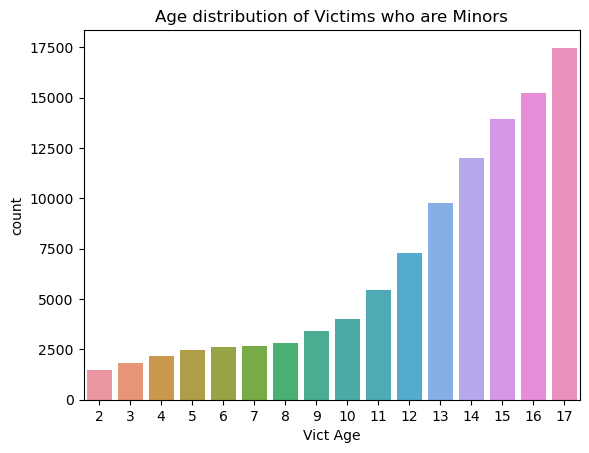

In [18]:
sns.barplot(x = 'Vict Age', y = 'count', data = rslt_df)
plt.title('Age distribution of Victims who are Minors')

plt.show()


The above distribution provides a Victim Age vs Count Distribution in the minor age group category. It can be found that with an increase in age, the number of crimes an individual is involved in increases. The count is maximum for Victims of Age 16 and 17. These two ages will later on be used to analyze the crime based on Area Name.  

### Filter for middle aged victims who are in the age group 18 to 50 

In [19]:
df_pandas = df_filtered.groupBy('Vict Age').count()
df_pandas = df_pandas.toPandas()
df_pandas = df_pandas.astype({'Vict Age':'int'})
rslt_df = df_pandas[(df_pandas['Vict Age'] >= 18) & (df_pandas['Vict Age'] <50)]

rslt_df

,Vict Age,count
5,29,45980
7,42,32212
12,30,45207
13,34,40369
16,28,46546
17,22,41903
19,35,41384
24,47,30830
27,43,31762
29,31,43132


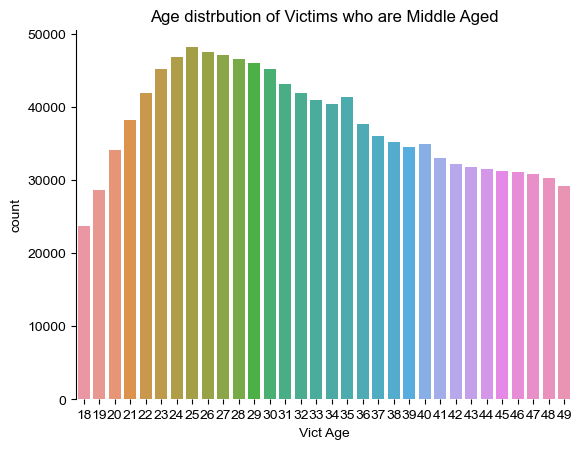

In [20]:
sns.barplot(x = 'Vict Age', y = 'count', data = rslt_df)
sns.despine(bottom=True)
sns.set(rc={'figure.figsize':(15,15)})

plt.title('Age distrbution of Victims who are Middle Aged')

plt.show()


     The above middle age distribution shows the Victim Age in the Middle Age category. 

### Filter for Victims Age greater than 50 who are Seniors.  

In [21]:
df_pandas = df_filtered.groupBy('Vict Age').count()
df_pandas = df_pandas.toPandas()
df_pandas = df_pandas.astype({'Vict Age':'int'})
rslt_df = df_pandas[(df_pandas['Vict Age']>=50)]

rslt_df

,Vict Age,count
0,51,27932
2,54,25144
6,69,8033
8,73,4892
9,87,1203
10,64,12686
14,59,19156
18,85,1540
20,52,27137
22,71,6349


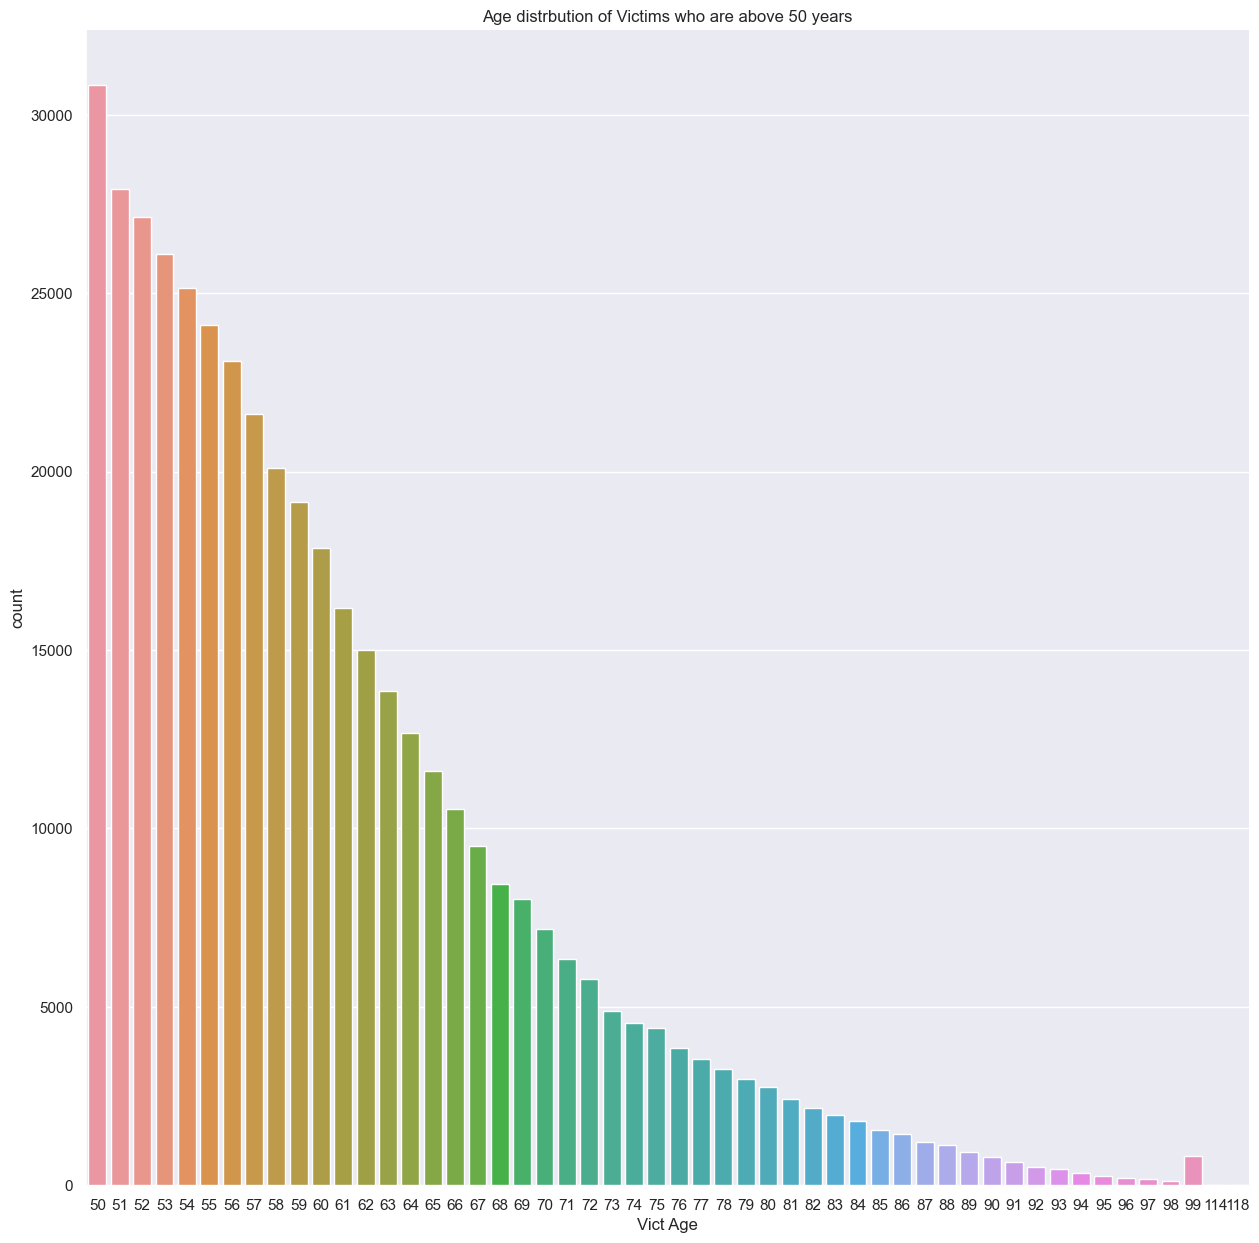

In [22]:
sns.barplot(x = 'Vict Age', y = 'count', data = rslt_df)
sns.despine(bottom=True)
sns.set(rc={'figure.figsize':(15,15)})

plt.title('Age distrbution of Victims who are above 50 years')

plt.show()


The above analysis shows that with an increase in Victim Age, there is a reduction in number of crimes. However, there is an outlier where there is a slight increase in crimes in 99 year olds.

### Group Data based on Area Name and Victim Age

In [23]:
analysis_2 = df_filtered.groupBy("AREA NAME","Vict Age").count().orderBy('AREA NAME','Vict Age').toPandas()

In [24]:
analysis_2

,AREA NAME,Vict Age,count
0,77th Street,10,487
1,77th Street,11,609
2,77th Street,12,785
3,77th Street,13,1002
4,77th Street,14,1381
...,...,...,...
2055,Wilshire,95,15
2056,Wilshire,96,12
2057,Wilshire,97,10
2058,Wilshire,98,8


In [25]:
analysis_2 = analysis_2.astype({'Vict Age':'int'})

rslt_df = analysis_2[analysis_2['Vict Age'] < 18]


In [26]:
rslt_df

,AREA NAME,Vict Age,count
0,77th Street,10,487
1,77th Street,11,609
2,77th Street,12,785
3,77th Street,13,1002
4,77th Street,14,1381
...,...,...,...
2005,Wilshire,5,67
2016,Wilshire,6,76
2027,Wilshire,7,65
2038,Wilshire,8,72


In [27]:
an = rslt_df.sort_values(by=['count'], ascending=False)


In [28]:
an

,AREA NAME,Vict Age,count
1478,Southwest,17,2292
1477,Southwest,16,1716
7,77th Street,17,1617
5,77th Street,15,1535
6,77th Street,16,1481
...,...,...,...
1798,West LA,4,32
1776,West LA,2,31
120,Central,3,30
175,Central,8,27


In [29]:
an_final = an[an['Vict Age'] == 17]


In [30]:
an_final

,AREA NAME,Vict Age,count
1478,Southwest,17,2292
7,77th Street,17,1617
1380,Southeast,17,1205
1282,Rampart,17,1114
694,Mission,17,1036
890,Newton,17,999
400,Harbor,17,987
1577,Topanga,17,736
498,Hollenbeck,17,735
204,Devonshire,17,730


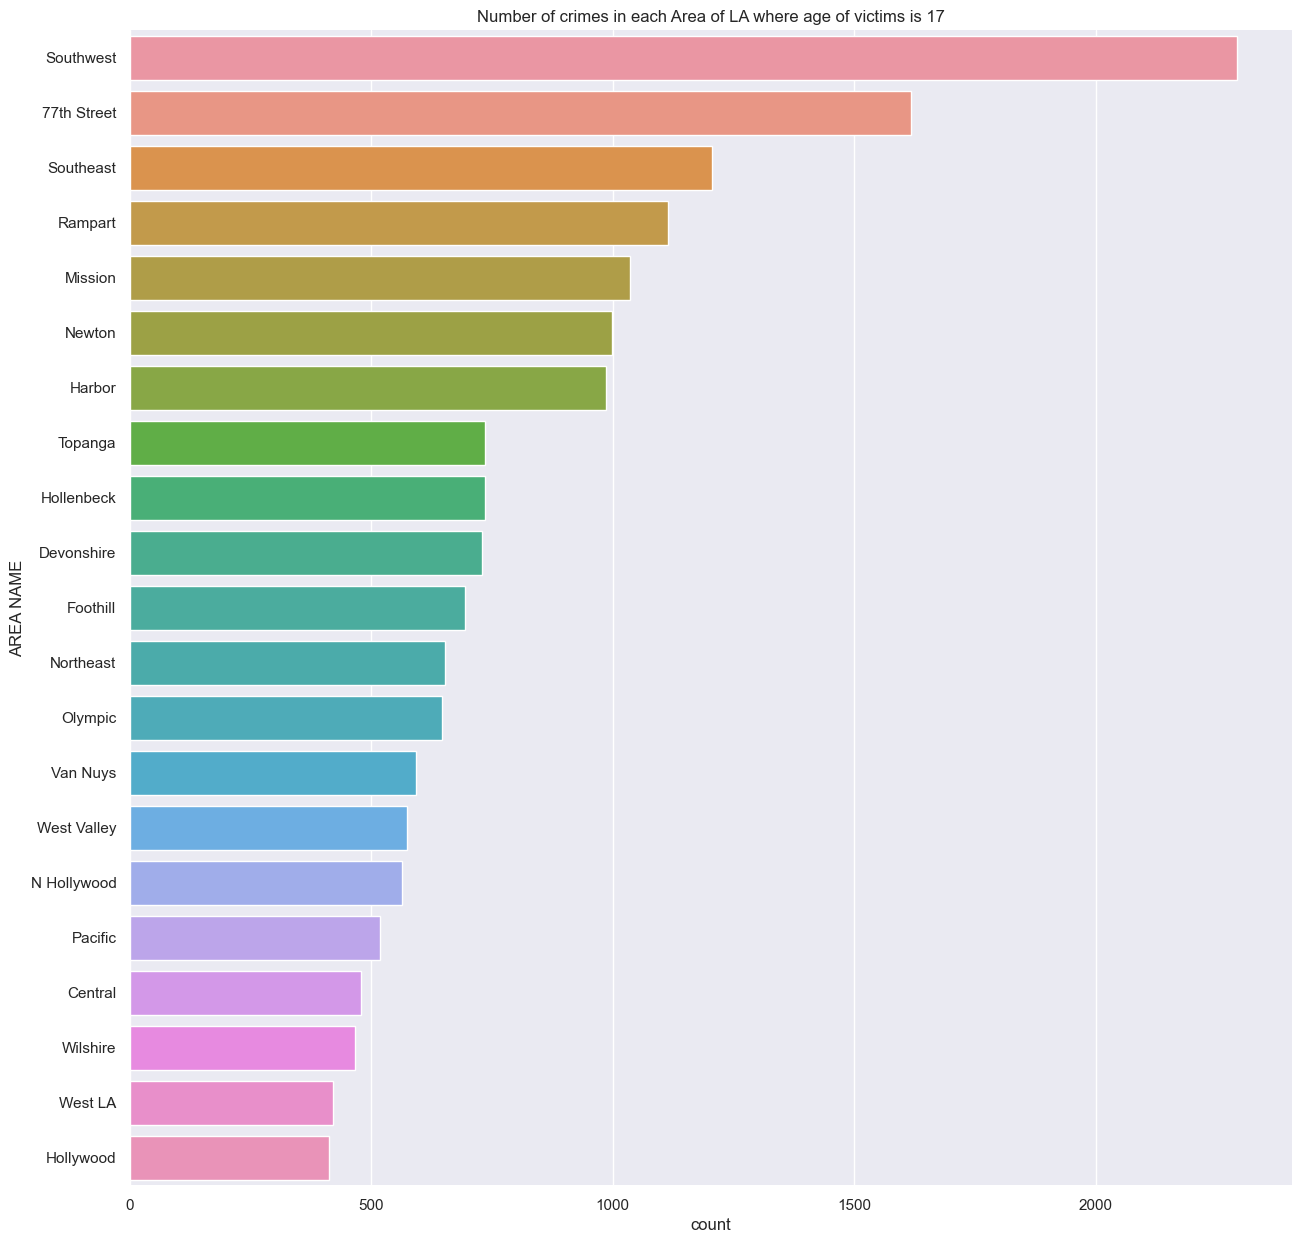

In [31]:
sns.barplot(x = 'count', y = 'AREA NAME', data = an_final)
sns.despine(bottom=True)
plt.title('Number of crimes in each Area of LA where age of victims is 17')

plt.show()


The above trend shows the Area in Los Angeles where crime is maximum for 17 year old Victims. It can be observed that the graph is in decreasing order. It can be inferred that 17 year olds need to be more aware in Southwest, 77th Street and Southeast.

In [32]:
an = rslt_df.sort_values(by=['count'], ascending=False)

an_16 = an[an['Vict Age'] == 16]


In [33]:
an_16

,AREA NAME,Vict Age,count
1477,Southwest,16,1716
6,77th Street,16,1481
1379,Southeast,16,1130
889,Newton,16,971
1281,Rampart,16,931
693,Mission,16,921
399,Harbor,16,824
497,Hollenbeck,16,683
301,Foothill,16,653
1576,Topanga,16,650


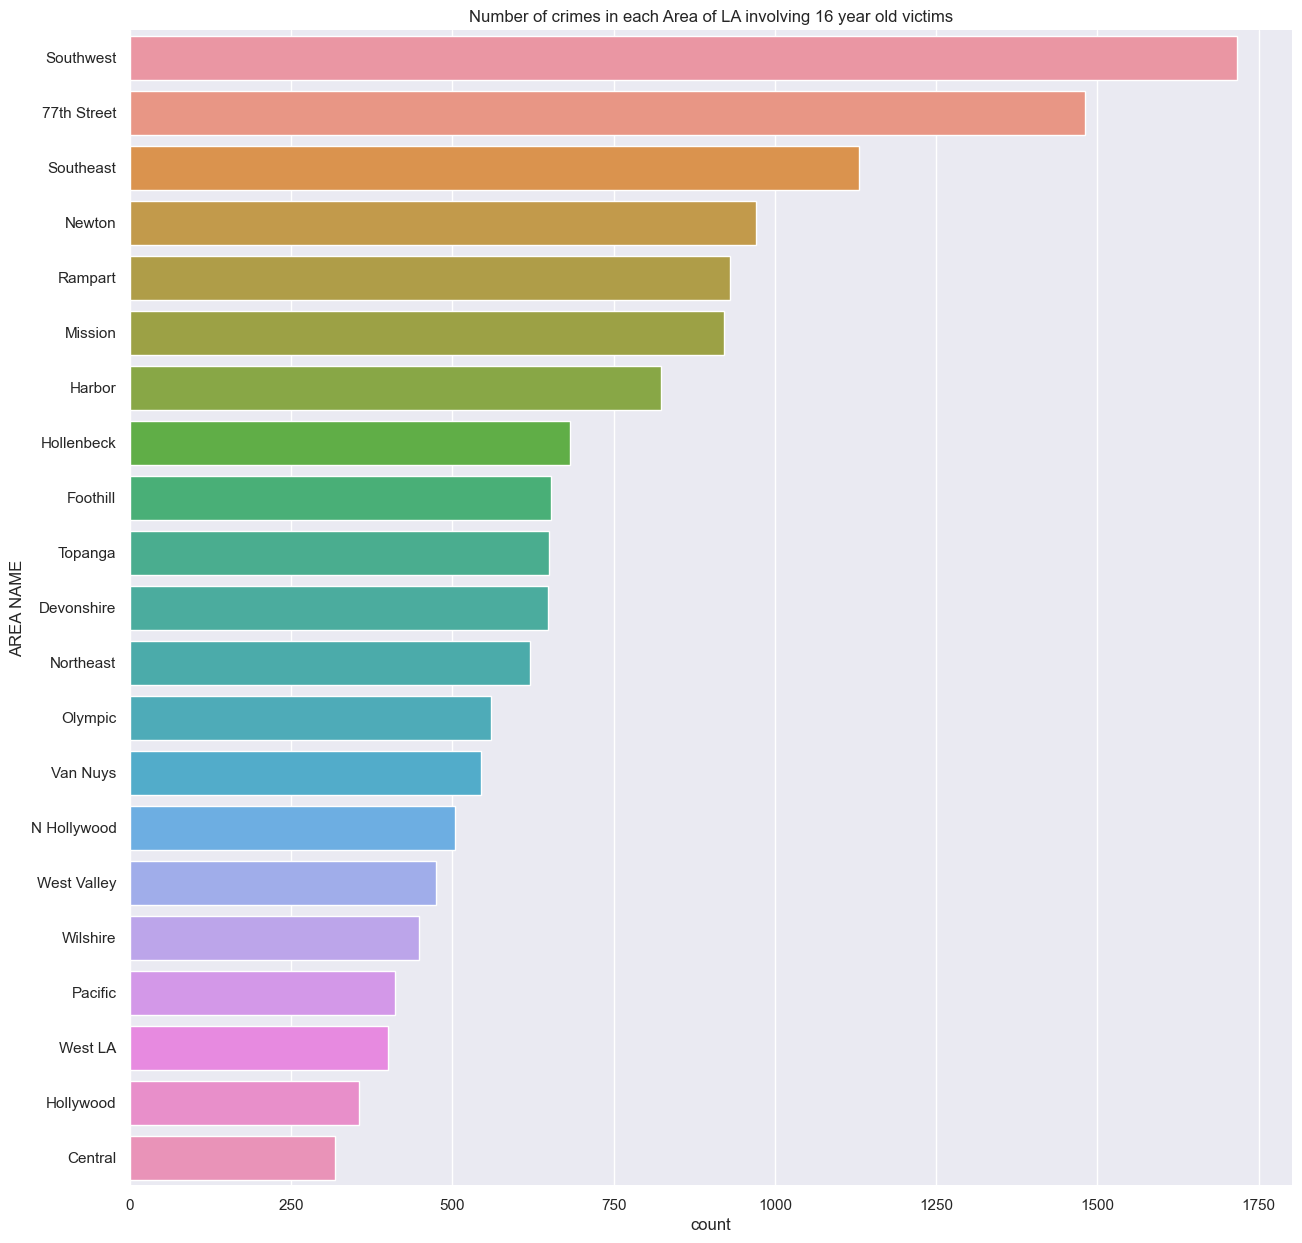

In [34]:
sns.barplot(x = 'count', y = 'AREA NAME', data = an_16)
sns.despine(bottom=True)
plt.title('Number of crimes in each Area of LA involving 16 year old victims')

plt.show()

The above trend shows the Area in Los Angeles where crime is maximum for 16 year old Victims. It can be observed that the graph is in decreasing order. It can be inferred that 16 year olds need to be more aware in Southwest, 77th Street and Southeast.